In [94]:
#!/usr/bin/env python
# coding=utf-8
# -------- import basic package --------
%pylab inline
import pdb
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import warnings
import random
from datetime import datetime
import matplotlib.pylab as plt

PATH = 'F:/codeGit/dataset/Purchase&Redemption/'
FILE_BANK = 'mfd_bank_shibor.csv'
FILE_SHARE = 'mfd_day_share_interest.csv'
FILE_USER_BALANCE = 'user_balance_table.csv'
FILE_USER_PROFILE = 'user_profile_table.csv'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### 读取用户的买入与赎回数据进行分析：

In [96]:
df_userBalan = pd.read_csv(PATH + FILE_USER_BALANCE)
print df_userBalan[:10]

   user_id  report_date  tBalance  yBalance  total_purchase_amt  \
0        1     20140805     20385     20383                   2   
1        1     20140808     20391     20389                   2   
2        1     20140811     20397     20395                   2   
3        1     20140814     20403     20401                   2   
4        1     20140817     20409     20407                   2   
5        1     20140820     20415     20413                   2   
6        1     20140823     20421     20419                   2   
7        1     20140826     20427     20425                   2   
8        1     20140829     20433     20431                   2   
9        1     20140830     20435     20433                   2   

   direct_purchase_amt  purchase_bal_amt  purchase_bank_amt  total_redeem_amt  \
0                    0                 0                  0                 0   
1                    0                 0                  0                 0   
2                  

### 查看该文件的缺失率：


 ratio of the missing value for every column:

inedx 0 user_id: no missing value
inedx 1 report_date: no missing value
inedx 2 tBalance: no missing value
inedx 3 yBalance: no missing value
inedx 4 total_purchase_amt: no missing value
inedx 5 direct_purchase_amt: no missing value
inedx 6 purchase_bal_amt: no missing value
inedx 7 purchase_bank_amt: no missing value
inedx 8 total_redeem_amt: no missing value
inedx 9 consume_amt: no missing value
inedx 10 transfer_amt: no missing value
inedx 11 tftobal_amt: no missing value
inedx 12 tftocard_amt: no missing value
inedx 13 share_amt: no missing value
inedx 14 category1: 93.88%
inedx 15 category2: 93.88%
inedx 16 category3: 93.88%
inedx 17 category4: 93.88%

 ratio of the missing value for the table: 20.86%
                    col  loss_ratio
0               user_id    0.000000
1           report_date    0.000000
2              tBalance    0.000000
3              yBalance    0.000000
4    total_purchase_amt    0.000000
5   direct_purchase_

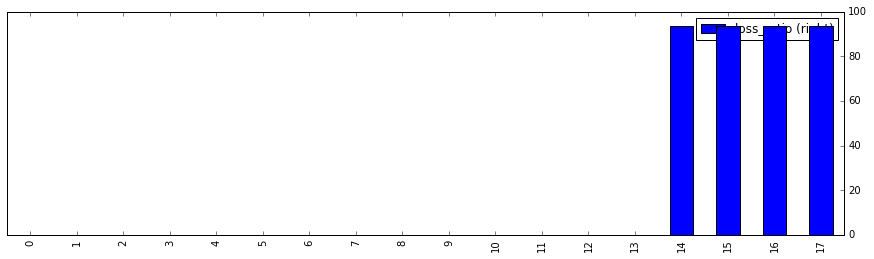

In [98]:
## 查看列缺失率
def detectMissingRatio(df):
    # pdb.set_trace()
    print("\n ratio of the missing value for every column:\n")

    columns = df.columns.tolist()
    lossRatio = []
    index = 0
    for col in columns:
        if df[col].count() == df[col].size:
            print 'inedx %d %s: no missing value' %(index, col)
            lossRatio.append(0)
        else: 
            print 'inedx %d %s: %.2f%%' %(index, col, (1.0 - 1.0 * df[col].count() / df[col].size) * 100)
            lossRatio.append((1.0 - 1.0 * df[col].count() / df[col].size) * 100)
        index = index + 1

    print '\n ratio of the missing value for the table: %.2f%%' %((1.0 - 1.0 * df.count().sum() / df.size)  * 100)
    df_statis = DataFrame(np.array([columns, lossRatio]).T, columns = ['col', 'loss_ratio'])
    df_statis['loss_ratio'] = df_statis['loss_ratio'].apply(lambda x : float(x))
    print df_statis
    df_statis.plot(kind='bar', secondary_y=['loss_ratio'], figsize=(15, 4))  
detectMissingRatio(df_userBalan)


### 数据的预处理：
以下是一些列之间的关系：
- tBalance  yBalance ：分别为今日余额与昨日余额  
- total_purchase_amt （总购买余额宝） = direct_purchase_amt  + share_amt 
    - 其中direct_purchase_amt  （直接购买量） = purchase_bal_amt  + purchase_bank_amt
- total_redeem_amt （总赎回余额宝） = consume_amt  + transfer_amt （转出量）
    - transfer_amt （转出量）= tftobal_amt  + tftocard_amt   
    
根据上面的结果，做主观分析，抽取价值高的列。     
1、以上的特征，yBalance =  tBalance + total_purchase_amt - total_redeem_amt   
2、上面的特征purchase_bal_amt  + purchase_bank_amt  基本没有区别，direct_purchase_amt  + share_amt 也没有区别，故直接使用特征 **total_purchase_amt**  
3、上面的特征为消费与转出的性质差别非常大，转出到余额与银行的性质差别不清楚（暂时认为一样）。故使用两个特征**consume_amt ， transfer_amt**   
4、category1, category2  category3  category4的缺失率高，考虑丢弃  



In [99]:
df_userBalan = df_userBalan[["user_id", "report_date", "total_purchase_amt", "consume_amt", "transfer_amt"]]
df_userBalan['time'] = pd.to_datetime(df_userBalan['report_date'], format = '%Y%m%d')
df_userBalan = df_userBalan.drop(['report_date'], axis = 1)
df_userBalan['year_month'] = df_userBalan['time'].dt.strftime('%Y-%m')
df_userBalan['day'] = df_userBalan['time'].dt.day
df_userBalan.set_index(['user_id', 'year_month'])
print df_userBalan[:5]

   user_id  total_purchase_amt  consume_amt  transfer_amt       time  \
0        1                   2            0             0 2014-08-05   
1        1                   2            0             0 2014-08-08   
2        1                   2            0             0 2014-08-11   
3        1                   2            0             0 2014-08-14   
4        1                   2            0             0 2014-08-17   

  year_month  day  
0    2014-08    5  
1    2014-08    8  
2    2014-08   11  
3    2014-08   14  
4    2014-08   17  


### 为用户进行分类：

In [157]:
temp_gp = df_userBalan.groupby(['user_id', 'year_month'])
df_mcp = DataFrame(dict(
        max_consume = temp_gp.consume_amt.max(),
        max_purchase = temp_gp.total_purchase_amt.max()
    )).reset_index()
df_mcp = df_mcp[pd.notnull(df_mcp['max_consume'])]
print df_mcp[:5]

   user_id year_month  max_consume  max_purchase
0        1    2014-03            0         20111
1        1    2014-04            0             2
2        1    2014-05            0             2
3        1    2014-06            0             2
4        1    2014-07            0             2


In [170]:
df_mcp['max_consume_layer'] = df_mcp.max_consume.apply(lambda x : (int(x / 1000000) + 1) * 10000)
df_mcp['max_purchase_layer'] = df_mcp.max_purchase.apply(lambda x : (int(x / 1000000) + 1) * 10000) 

In [171]:
def drawDistribuMap(df, columns):
    fig = plt.figure()
    colorList = ['r', 'b', 'g', 'y', 'c']
    for col in columns:
        if col == df.columns[0]:
            sentryCol = df.columns[1]
        else: 
            sentryCol = df.columns[0]
        df_cnt = df.groupby(col).count()[[sentryCol]]
        df_cnt.columns = ['cnt']

        color = colorList[random.randint(0, len(colorList) - 1)]
        # print df_cnt
        df_cnt.plot(kind='bar', figsize=(15, 4))

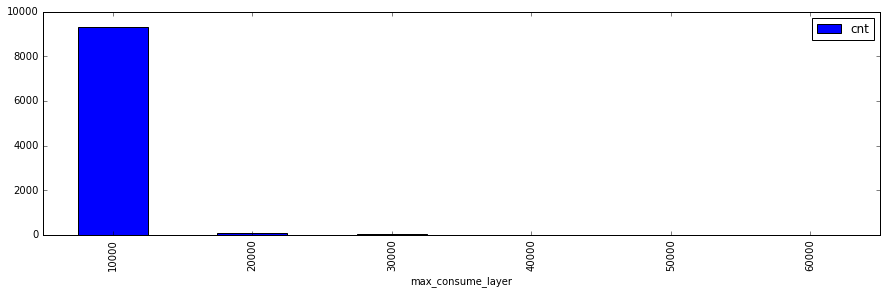

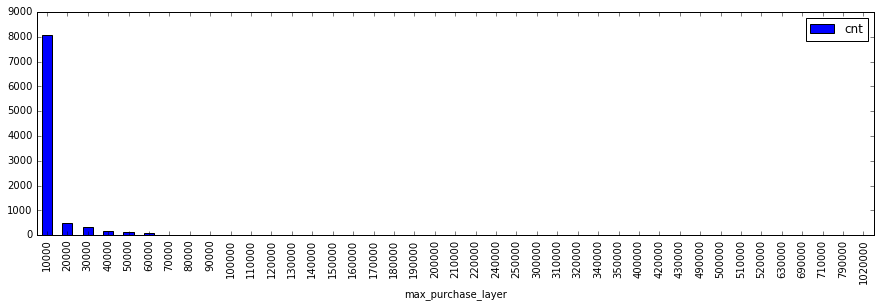

In [172]:
drawDistribuMap(df_mcp[df_mcp.year_month == '2014-01'], ['max_consume_layer', 'max_purchase_layer']) 

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


   year_month    cnt
0     2013-07    2.0
1     2013-08    5.0
2     2013-09   15.0
3     2013-10   25.0
4     2013-11   59.0
5     2013-12   91.0
6     2014-01  142.0
7     2014-02  157.0
8     2014-03  190.0
9     2014-04  185.0
10    2014-05  207.0
11    2014-06  225.0
12    2014-07  261.0
13    2014-08  314.0


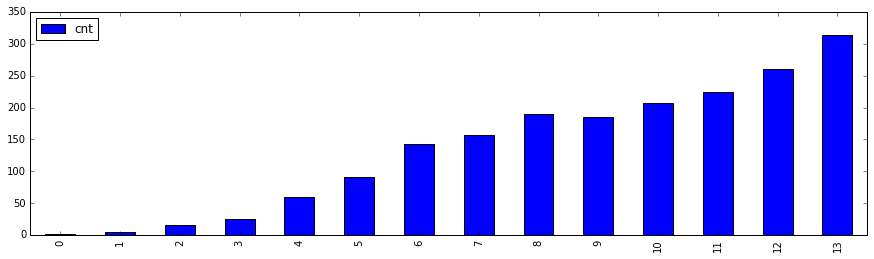

In [134]:
def selectClassBoundForUser(df, n):
    ymCnts = []
    ymList = Series(df_mcp.year_month.unique()).order().values.tolist()
    for ym in ymList:
        df_ym = df[df.year_month == ym]
        ymCnts.append(df_ym[df_ym.max_consume > n].count().values[0])
        
    df_statis = DataFrame(np.array([ymList, ymCnts]).T, columns = ['year_month', 'cnt'])
    df_statis['cnt'] = df_statis['cnt'].apply(lambda x : float(x))
    print df_statis
    df_statis.plot(kind='bar', secondary_y=['loss_ratio'], figsize=(15, 4))  
selectClassBoundForUser(df_mcp, 10000)

### 查看总购买与总赎回的趋势曲线：

#### 某个月的的趋势曲线：

    day  total_purchase  total_reedom
0     1       330926565      77367755
1     2       434956739     190155450
2     3       342074805     127714255
3     4       186085910      99869074
4     5       206030707     156781996
5     6       442494042     190917629
6     7       589726496     137972793
7     8       264025160     213880074
8     9       280698487     140391237
9    10       237797636     117259153
10   11       243403438      71530182
11   12       228255344     141505812
12   13       447207050     178923772
13   14       356907128     159778389
14   15       391408718     177618247
15   16       374947083     153167426
16   17       345426853     127385210
17   18       233200688     142869842
18   19       185082022     117629351
19   20       335761027     442996084
20   21       412854611     302825136
21   22       498730606     292856188
22   23       481450097     209024328
23   24       614103894     345829001
24   25       440854623     185524856
25   26     

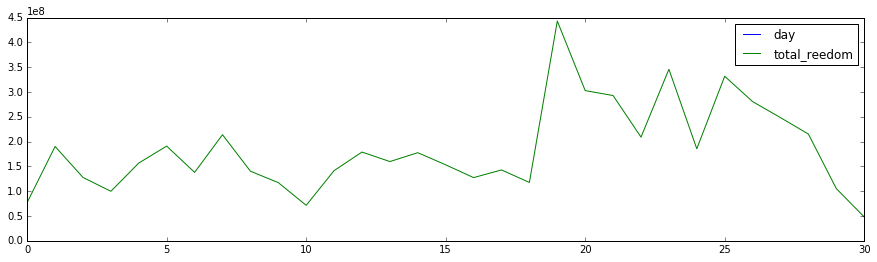

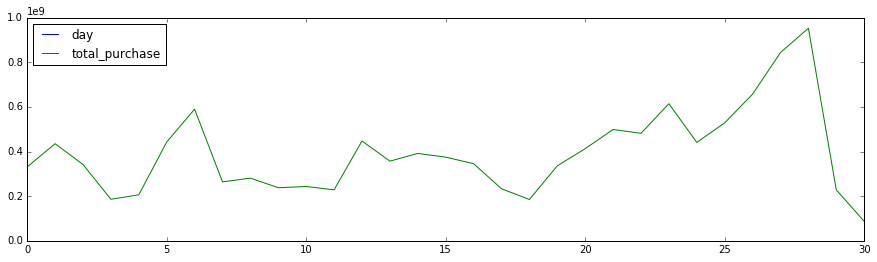

In [144]:
ymList = Series(df_mcp.year_month.unique()).order().values.tolist()
for ym in ymList:
    df_ym = df_userBalan[df_userBalan.year_month == ym]
    temp_gp = df_ym.groupby(['day'])
    df_rp = DataFrame(dict(
        total_reedom = temp_gp.consume_amt.sum() + temp_gp.transfer_amt.sum(),
        total_purchase = temp_gp.total_purchase_amt.sum(),
    )).reset_index()
    
df_rp[['day', 'total_reedom']].plot(kind='line', figsize=(15, 4))  
df_rp[['day', 'total_purchase']].plot(kind='line', figsize=(15, 4))


#### 全部十二个月的的趋势曲线：

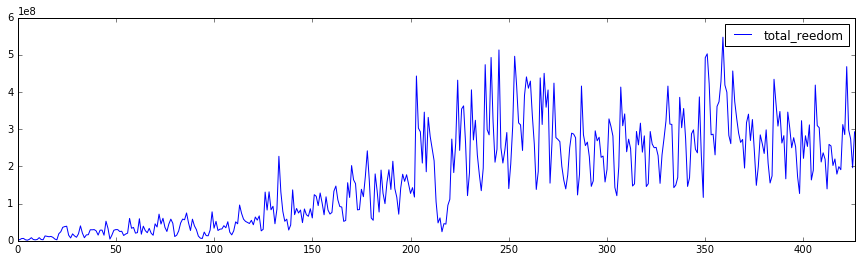

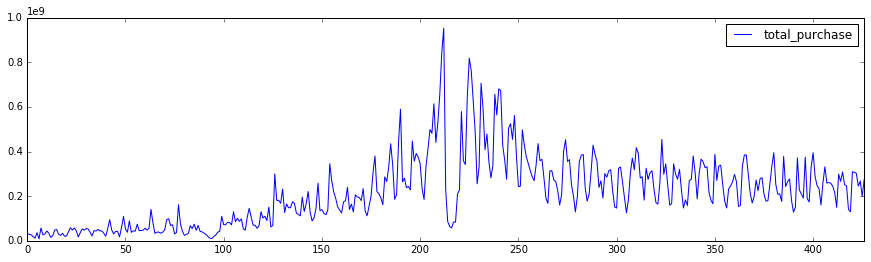

In [148]:
temp_gp = df_userBalan.groupby(['time'])
df_rp_date = DataFrame(dict(
    total_reedom = temp_gp.consume_amt.sum() + temp_gp.transfer_amt.sum(),
    total_purchase = temp_gp.total_purchase_amt.sum(),
    )).reset_index()
    
df_rp_date[['time', 'total_reedom']].plot(kind='line', figsize=(15, 4))  
df_rp_date[['time', 'total_purchase']].plot(kind='line', figsize=(15, 4))

In [95]:
df_userProf = pd.read_csv(PATH + FILE_USER_PROFILE)
print df_userProf[:10]

   user_id  sex     city constellation
0        2    1  6411949           狮子座
1       12    1  6412149           摩羯座
2       22    1  6411949           双子座
3       23    1  6411949           双鱼座
4       25    1  6481949           双鱼座
5       26    1  6281949           双子座
6       34    0  6481949           摩羯座
7       36    1  6281949           天秤座
8       42    0  6281949           水瓶座
9       47    1  6412149           天蝎座


In [6]:
df_share = pd.read_csv(PATH + FILE_SHARE)
df_share[:10]

,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,20130701,1.5787,6.307
1,20130702,1.5461,6.174
2,20130703,1.4670,6.034
3,20130704,1.4223,5.903
4,20130705,1.3845,5.739
5,20130706,1.3674,5.582
6,20130707,1.3671,5.425
7,20130708,1.3129,5.279
8,20130709,1.3096,5.150
9,20130710,1.2792,5.047


In [14]:
df_bank = pd.read_csv(PATH + FILE_BANK)
print df_bank[:10]

   mfd_date  Interest_O_N  Interest_1_W  Interest_2_W  Interest_1_M  \
0  20130701        4.4560         5.423         6.040        6.8800   
1  20130702        3.7860         4.750         5.074        5.8000   
2  20130703        3.4000         4.242         4.658        5.2000   
3  20130704        3.3480         3.938         4.464        5.1020   
4  20130705        3.3800         3.816         4.295        4.7885   
5  20130708        3.2560         3.656         3.686        4.3000   
6  20130709        3.2490         3.596         3.604        4.2980   
7  20130710        3.2510         3.590         3.850        4.2690   
8  20130711        3.3547         3.810         3.906        4.3510   
9  20130712        3.3000         3.800         3.928        4.1280   

   Interest_3_M  Interest_6_M  Interest_9_M  Interest_1_Y  
0        5.2950        4.2390        4.2820        4.4125  
1        5.2110        4.2344        4.2808        4.4070  
2        5.1480        4.2300        4